In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [11]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dropout (Dropout)    

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.0446 - acc: 0.4305
Epoch 00001: val_loss improved from inf to 1.47300, saving model to model/checkpoint/2D_CNN_1_only_conv_DO_BN_checkpoint/01-1.4730.hdf5
36805/36805 [==============================] - 14s 369us/sample - loss: 2.0439 - acc: 0.4307 - val_loss: 1.4730 - val_acc: 0.5865
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6387 - acc: 0.5329
Epoch 00002: val_loss improved from 1.47300 to 1.44872, saving model to model/checkpoint/2D_CNN_1_only_conv_DO_BN_checkpoint/02-1.4487.hdf5
36805/36805 [==============================] - 12s 315us/sample - loss: 1.6381 - acc: 0.5331 - val_loss: 1.4487 - val_acc: 0.5879
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.4856 - acc: 0.5735
Epoch 00003: val_loss improved from 1.44872 to 1.39063, saving model to model/c

Epoch 25/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6133 - acc: 0.8081
Epoch 00025: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 309us/sample - loss: 0.6132 - acc: 0.8082 - val_loss: 1.1450 - val_acc: 0.7209
Epoch 26/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6108 - acc: 0.8060
Epoch 00026: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 312us/sample - loss: 0.6111 - acc: 0.8059 - val_loss: 1.1668 - val_acc: 0.7174
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5896 - acc: 0.8119
Epoch 00027: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 310us/sample - loss: 0.5896 - acc: 0.8120 - val_loss: 1.1867 - val_acc: 0.7105
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.5894 - acc: 0.8130
Epoch 00028: val_loss did not improve from 1.12856
36805/36805 [=====

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4373 - acc: 0.8595
Epoch 00055: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 310us/sample - loss: 0.4373 - acc: 0.8594 - val_loss: 1.2795 - val_acc: 0.7305
Epoch 56/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4429 - acc: 0.8569
Epoch 00056: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 309us/sample - loss: 0.4436 - acc: 0.8568 - val_loss: 1.2920 - val_acc: 0.7221
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4399 - acc: 0.8578
Epoch 00057: val_loss did not improve from 1.12856
36805/36805 [==============================] - 11s 304us/sample - loss: 0.4396 - acc: 0.8578 - val_loss: 1.2596 - val_acc: 0.7317
Epoch 58/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4339 - acc: 0.8610
Epoch 00058: val_loss did not improve from 1.12856
36805/36805 [=====

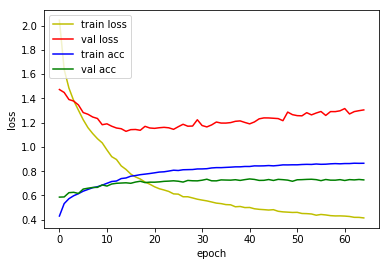

4815/4815 [==============================] - 1s 223us/sample - loss: 1.2333 - acc: 0.6741
Loss: 1.2332580039310554 Accuracy: 0.6741433

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.0388 - acc: 0.3914
Epoch 00001: val_loss improved from inf to 1.37255, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/01-1.3725.hdf5
36805/36805 [==============================] - 15s 408us/sample - loss: 2.0379 - acc: 0.3916 - val_loss: 1.3725 - val_acc: 0.5935
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.4067 - acc: 0.5727
Epoch 00002: val_loss improved from 1.37255 to 1.12099, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/02-1.1210.hdf5
36805/36805 [==============================] - 13s 365us/sample - loss: 1.4064 - acc: 0.5728 - val_loss: 1.1210 - val_acc: 0.6797
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.1592 - acc

Epoch 24/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.3563 - acc: 0.8890
Epoch 00024: val_loss improved from 0.56064 to 0.55386, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/24-0.5539.hdf5
36805/36805 [==============================] - 14s 391us/sample - loss: 0.3563 - acc: 0.8890 - val_loss: 0.5539 - val_acc: 0.8705
Epoch 25/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.3398 - acc: 0.8946
Epoch 00025: val_loss improved from 0.55386 to 0.55059, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/25-0.5506.hdf5
36805/36805 [==============================] - 15s 406us/sample - loss: 0.3399 - acc: 0.8945 - val_loss: 0.5506 - val_acc: 0.8677
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.8946
Epoch 00026: val_loss improved from 0.55059 to 0.54125, saving model to model/checkpoint/2D_CNN_2_only_conv_DO_BN_checkpoint/26-0.5413.hdf5
36805/36805 [================

Epoch 52/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9338
Epoch 00052: val_loss did not improve from 0.52379
36805/36805 [==============================] - 12s 339us/sample - loss: 0.2127 - acc: 0.9337 - val_loss: 0.5341 - val_acc: 0.8824
Epoch 53/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9345
Epoch 00053: val_loss did not improve from 0.52379
36805/36805 [==============================] - 13s 342us/sample - loss: 0.2112 - acc: 0.9345 - val_loss: 0.5412 - val_acc: 0.8840
Epoch 54/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9347
Epoch 00054: val_loss did not improve from 0.52379
36805/36805 [==============================] - 13s 342us/sample - loss: 0.2106 - acc: 0.9348 - val_loss: 0.5789 - val_acc: 0.8751
Epoch 55/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2071 - acc: 0.9351
Epoch 00055: val_loss did not improve from 0.52379
36805/36805 [=====

Epoch 81/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1579 - acc: 0.9518
Epoch 00081: val_loss did not improve from 0.50984
36805/36805 [==============================] - 12s 336us/sample - loss: 0.1580 - acc: 0.9519 - val_loss: 0.5232 - val_acc: 0.8873
Epoch 82/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9515
Epoch 00082: val_loss did not improve from 0.50984
36805/36805 [==============================] - 13s 344us/sample - loss: 0.1566 - acc: 0.9516 - val_loss: 0.5329 - val_acc: 0.8910
Epoch 83/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1537 - acc: 0.9532
Epoch 00083: val_loss did not improve from 0.50984
36805/36805 [==============================] - 13s 342us/sample - loss: 0.1537 - acc: 0.9532 - val_loss: 0.5383 - val_acc: 0.8847
Epoch 84/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9523
Epoch 00084: val_loss did not improve from 0.50984
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9621
Epoch 00110: val_loss did not improve from 0.50984
36805/36805 [==============================] - 13s 361us/sample - loss: 0.1213 - acc: 0.9621 - val_loss: 0.5268 - val_acc: 0.8908
Epoch 111/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9624
Epoch 00111: val_loss did not improve from 0.50984
36805/36805 [==============================] - 13s 361us/sample - loss: 0.1236 - acc: 0.9625 - val_loss: 0.5285 - val_acc: 0.8915
Epoch 112/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9616
Epoch 00112: val_loss did not improve from 0.50984
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1254 - acc: 0.9616 - val_loss: 0.5240 - val_acc: 0.8921
Epoch 113/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9619
Epoch 00113: val_loss did not improve from 0.50984
36805/36805 [===============

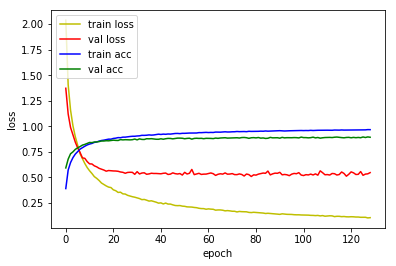

4815/4815 [==============================] - 1s 238us/sample - loss: 0.6056 - acc: 0.8540
Loss: 0.6055759042470502 Accuracy: 0.85399795

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.1690 - acc: 0.3387
Epoch 00001: val_loss improved from inf to 1.36442, saving model to model/checkpoint/2D_CNN_3_only_conv_DO_BN_checkpoint/01-1.3644.hdf5
36805/36805 [==============================] - 17s 462us/sample - loss: 2.1688 - acc: 0.3389 - val_loss: 1.3644 - val_acc: 0.5945
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.3735 - acc: 0.5714
Epoch 00002: val_loss improved from 1.36442 to 1.01208, saving model to model/checkpoint/2D_CNN_3_only_conv_DO_BN_checkpoint/02-1.0121.hdf5
36805/36805 [==============================] - 15s 400us/sample - loss: 1.3732 - acc: 0.5714 - val_loss: 1.0121 - val_acc: 0.7035
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0483 - ac

Epoch 25/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.2653 - acc: 0.9170
Epoch 00025: val_loss improved from 0.32047 to 0.31430, saving model to model/checkpoint/2D_CNN_3_only_conv_DO_BN_checkpoint/25-0.3143.hdf5
36805/36805 [==============================] - 15s 395us/sample - loss: 0.2654 - acc: 0.9170 - val_loss: 0.3143 - val_acc: 0.9140
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2564 - acc: 0.9188
Epoch 00026: val_loss did not improve from 0.31430
36805/36805 [==============================] - 15s 397us/sample - loss: 0.2564 - acc: 0.9188 - val_loss: 0.3635 - val_acc: 0.9001
Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2497 - acc: 0.9212
Epoch 00027: val_loss did not improve from 0.31430
36805/36805 [==============================] - 14s 393us/sample - loss: 0.2495 - acc: 0.9213 - val_loss: 0.3158 - val_acc: 0.9164
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9467
Epoch 00052: val_loss did not improve from 0.25354
36805/36805 [==============================] - 14s 393us/sample - loss: 0.1651 - acc: 0.9467 - val_loss: 0.2739 - val_acc: 0.9301
Epoch 53/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1643 - acc: 0.9471
Epoch 00053: val_loss did not improve from 0.25354
36805/36805 [==============================] - 14s 393us/sample - loss: 0.1644 - acc: 0.9470 - val_loss: 0.2663 - val_acc: 0.9341
Epoch 54/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1580 - acc: 0.9495
Epoch 00054: val_loss did not improve from 0.25354
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1580 - acc: 0.9495 - val_loss: 0.2653 - val_acc: 0.9378
Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9489
Epoch 00055: val_loss did not improve from 0.25354
36805/36805 [==================

Epoch 81/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9619
Epoch 00081: val_loss did not improve from 0.25063
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1206 - acc: 0.9619 - val_loss: 0.2829 - val_acc: 0.9355
Epoch 82/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9607
Epoch 00082: val_loss did not improve from 0.25063
36805/36805 [==============================] - 15s 397us/sample - loss: 0.1201 - acc: 0.9608 - val_loss: 0.2559 - val_acc: 0.9411
Epoch 83/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1221 - acc: 0.9605
Epoch 00083: val_loss did not improve from 0.25063
36805/36805 [==============================] - 15s 399us/sample - loss: 0.1223 - acc: 0.9605 - val_loss: 0.2679 - val_acc: 0.9392
Epoch 84/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9631
Epoch 00084: val_loss did not improve from 0.25063
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9693
Epoch 00110: val_loss did not improve from 0.24639
36805/36805 [==============================] - 14s 394us/sample - loss: 0.0988 - acc: 0.9693 - val_loss: 0.2788 - val_acc: 0.9390
Epoch 111/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0963 - acc: 0.9694
Epoch 00111: val_loss did not improve from 0.24639
36805/36805 [==============================] - 15s 399us/sample - loss: 0.0962 - acc: 0.9694 - val_loss: 0.2620 - val_acc: 0.9432
Epoch 112/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9701
Epoch 00112: val_loss did not improve from 0.24639
36805/36805 [==============================] - 14s 394us/sample - loss: 0.0939 - acc: 0.9702 - val_loss: 0.2573 - val_acc: 0.9429
Epoch 113/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9697
Epoch 00113: val_loss did not improve from 0.24639
36805/36805 [===============

Epoch 140/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0807 - acc: 0.9742
Epoch 00140: val_loss did not improve from 0.24639
36805/36805 [==============================] - 15s 399us/sample - loss: 0.0807 - acc: 0.9742 - val_loss: 0.2852 - val_acc: 0.9394
Epoch 141/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0790 - acc: 0.9746
Epoch 00141: val_loss did not improve from 0.24639
36805/36805 [==============================] - 15s 398us/sample - loss: 0.0790 - acc: 0.9746 - val_loss: 0.2848 - val_acc: 0.9415

3 Only Conv Model


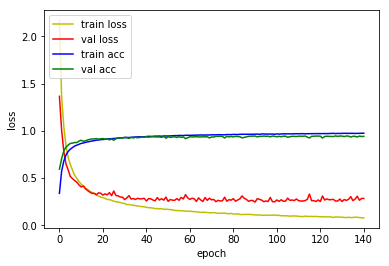

4815/4815 [==============================] - 1s 267us/sample - loss: 0.3214 - acc: 0.9126
Loss: 0.3213669447388852 Accuracy: 0.9125649

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.3097 - acc: 0.3023
Epoch 00001: val_loss improved from inf to 1.44584, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/01-1.4458.hdf5
36805/36805 [==============================] - 19s 516us/sample - loss: 2.3096 - acc: 0.3023 - val_loss: 1.4458 - val_acc: 0.5460
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.4696 - acc: 0.5284
Epoch 00002: val_loss improved from 1.44584 to 0.98767, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/02-0.9877.hdf5
36805/36805 [==============================] - 16s 424us/sample - loss: 1.4686 - acc: 0.5285 - val_loss: 0.9877 - val_acc: 0.7107
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0490 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9305
Epoch 00024: val_loss improved from 0.21506 to 0.21397, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/24-0.2140.hdf5
36805/36805 [==============================] - 15s 419us/sample - loss: 0.2179 - acc: 0.9306 - val_loss: 0.2140 - val_acc: 0.9401
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9328
Epoch 00025: val_loss did not improve from 0.21397
36805/36805 [==============================] - 16s 422us/sample - loss: 0.2137 - acc: 0.9328 - val_loss: 0.2293 - val_acc: 0.9341
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9335
Epoch 00026: val_loss improved from 0.21397 to 0.21142, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/26-0.2114.hdf5
36805/36805 [==============================] - 16s 422us/sample - loss: 0.2079 - acc: 0.9335 - val_loss: 0.2114 - val_acc: 0.9399
E

36736/36805 [============================>.] - ETA: 0s - loss: 0.1235 - acc: 0.9601
Epoch 00050: val_loss improved from 0.18209 to 0.18163, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/50-0.1816.hdf5
36805/36805 [==============================] - 15s 420us/sample - loss: 0.1236 - acc: 0.9601 - val_loss: 0.1816 - val_acc: 0.9511
Epoch 51/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9606
Epoch 00051: val_loss did not improve from 0.18163
36805/36805 [==============================] - 15s 418us/sample - loss: 0.1231 - acc: 0.9607 - val_loss: 0.1874 - val_acc: 0.9525
Epoch 52/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9620
Epoch 00052: val_loss improved from 0.18163 to 0.17298, saving model to model/checkpoint/2D_CNN_4_only_conv_DO_BN_checkpoint/52-0.1730.hdf5
36805/36805 [==============================] - 16s 422us/sample - loss: 0.1184 - acc: 0.9620 - val_loss: 0.1730 - val_acc: 0.9539
E

36800/36805 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9733
Epoch 00078: val_loss did not improve from 0.16764
36805/36805 [==============================] - 15s 417us/sample - loss: 0.0830 - acc: 0.9733 - val_loss: 0.1751 - val_acc: 0.9574
Epoch 79/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9722
Epoch 00079: val_loss did not improve from 0.16764
36805/36805 [==============================] - 16s 424us/sample - loss: 0.0869 - acc: 0.9722 - val_loss: 0.1835 - val_acc: 0.9564
Epoch 80/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0850 - acc: 0.9730
Epoch 00080: val_loss did not improve from 0.16764
36805/36805 [==============================] - 16s 424us/sample - loss: 0.0851 - acc: 0.9729 - val_loss: 0.1811 - val_acc: 0.9560
Epoch 81/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9748
Epoch 00081: val_loss did not improve from 0.16764
36805/36805 [==================

Epoch 108/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9787
Epoch 00108: val_loss did not improve from 0.16764
36805/36805 [==============================] - 15s 421us/sample - loss: 0.0657 - acc: 0.9786 - val_loss: 0.1943 - val_acc: 0.9581
Epoch 109/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0650 - acc: 0.9798
Epoch 00109: val_loss did not improve from 0.16764
36805/36805 [==============================] - 15s 417us/sample - loss: 0.0649 - acc: 0.9798 - val_loss: 0.1948 - val_acc: 0.9581
Epoch 110/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9809
Epoch 00110: val_loss did not improve from 0.16764
36805/36805 [==============================] - 15s 411us/sample - loss: 0.0611 - acc: 0.9809 - val_loss: 0.1887 - val_acc: 0.9585
Epoch 111/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9808
Epoch 00111: val_loss did not improve from 0.16764
36805/36805 [=

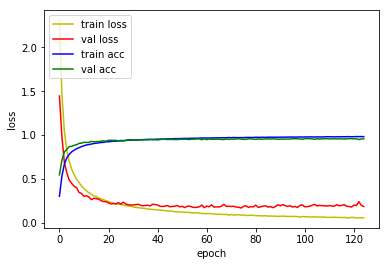

4815/4815 [==============================] - 1s 295us/sample - loss: 0.2459 - acc: 0.9371
Loss: 0.24588433228672973 Accuracy: 0.9370716



In [12]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO_BN'.format(i)
    model = build_2d_cnn_only_conv_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 253, 95, 8)        32        
_________________________________________________________________
activation_10 (Activation)   (None, 253, 95, 8)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 48768)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)     

4815/4815 [==============================] - 2s 324us/sample - loss: 0.2459 - acc: 0.9371
Loss: 0.24588433228672973 Accuracy: 0.9370716
